## Libraries

In [269]:
import sys
import os
import datetime as dt
import numpy as np
import pandas as pd
import geopandas as gpd
import altair as alt

In [270]:
if not 'mainDir' in globals():
    mainDir = os.path.dirname(os.getcwd()) # Get parent dir: os.path.dirname()
print(mainDir)

/Users/lassescheele/Documents/Private/altair-climate-change


## Settings

In [271]:
first_year = 1950
last_year = 2013
start_reference_period = 1961
end_reference_period = 1990

In [272]:
dir_input = os.path.join(mainDir,'data','raw')
dir_output = os.path.join(mainDir,'data','processed')

## Read data

### Read shapes

In [273]:
gdf = gpd.read_file(os.path.join(dir_input,"countries.geojson"))

In [274]:
gdf = gdf.rename(columns={'ADMIN':'Country'})

### Read climate data

In [275]:
df = pd.read_csv(os.path.join(dir_input,"GlobalLandTemperaturesByCountry.csv"))
df.shape

(577462, 4)

In [276]:
df = df[['dt','AverageTemperature','Country']]

In [277]:
df['dt'] = pd.to_datetime(df['dt'], format="%Y-%m-%d")
df = df.loc[(df['dt'].dt.year>=first_year) & (df['dt'].dt.year<=last_year)]
df['Year'] = df['dt'].dt.year
df['Month'] = df['dt'].dt.month
df.shape
df.head(3)

,dt,AverageTemperature,Country,Year,Month
2474,1950-01-01,-5.611,Åland,1950,1
2475,1950-02-01,-1.804,Åland,1950,2
2476,1950-03-01,0.090,Åland,1950,3


In [278]:
country_names_dict = {
    'Antigua And Barbuda':'Antigua and Barbuda',
    'Bahamas':'The Bahamas',
    'Bosnia And Herzegovina':'Bosnia and Herzegovina',
    'Burma':'Myanmar',
    'Congo':'Republic of Congo',
    'Congo (Democratic Republic Of The)':'Democratic Republic of the Congo',
    "Côte D'Ivoire":'Ivory Coast',
    'Falkland Islands (Islas Malvinas)':'Falkland Islands',
    'Federated States Of Micronesia':'Federated States of Micronesia',
    'French Southern And Antarctic Lands':'French Southern and Antarctic Lands',
    'Heard Island And Mcdonald Islands':'Heard Island and McDonald Islands',
    'Hong Kong':'Hong Kong S.A.R.',
    'Isle Of Man':'Isle of Man',
    'Macau':'Macao S.A.R',
    'Palestina':'Palestine',
    'Saint Barthélemy':'Saint Barthelemy',
    'Saint Kitts And Nevis':'Saint Kitts and Nevis',
    'Saint Pierre And Miquelon':'Saint Pierre and Miquelon',
    'Saint Vincent And The Grenadines':'Saint Vincent and the Grenadines',
    'Sao Tome And Principe':'Sao Tome and Principe',
    'Serbia':'Republic of Serbia',
    'South Georgia And The South Sandwich Isla':'South Georgia and South Sandwich Islands',
    'Tanzania':'United Republic of Tanzania',
    'Timor Leste':'East Timor',
    'Trinidad And Tobago':'Trinidad and Tobago',
    'Turks And Caicas Islands':'Turks and Caicos Islands',
    'United States':'United States of America',
    'Virgin Islands':'United States Virgin Islands',
    'Åland':'Aland'
}

In [279]:
for key in country_names_dict.keys():
    #print(key, country_names_dict[key])
    df.loc[df['Country']==key,'Country'] = country_names_dict[key]

## Prepare data

### Heatmap data

In [281]:
df_reference = df.loc[(df['Year']>=start_reference_period) & (df['Year']<=end_reference_period)]
df_reference = pd.DataFrame(df_reference.groupby(['Country','Month'])['AverageTemperature'].mean())
df_reference

AverageTemperature
Country     Month                    
Afghanistan 1                0.730100
            2                2.992767
            3                8.727800
            4               14.828133
            5               20.260133
...                               ...
Zimbabwe    8               18.463633
            9               21.972900
            10              23.935867
            11              24.438900
            12              23.849533

[2916 rows x 1 columns]

In [282]:
list_countries = df['Country'].unique().tolist()
country_counter = 1
for country in list_countries:
    if country_counter % 10 == 0:
        print(f"{country_counter} of {len(list_countries)} countries")
    for month in range(1,13):
        df.loc[
            (df['Country']==country) &
            (df['Month']==month),
            'AverageTemperature_ref'] = df.loc[
            (df['Country']==country) &
            (df['Month']==month),
            'AverageTemperature'] - df_reference.loc[(country,month),'AverageTemperature']
    country_counter += 1
    

10 of 243 countries
20 of 243 countries
30 of 243 countries
40 of 243 countries
50 of 243 countries
60 of 243 countries
70 of 243 countries
80 of 243 countries
90 of 243 countries
100 of 243 countries
110 of 243 countries
120 of 243 countries
130 of 243 countries
140 of 243 countries
150 of 243 countries
160 of 243 countries
170 of 243 countries
180 of 243 countries
190 of 243 countries
200 of 243 countries
210 of 243 countries
220 of 243 countries
230 of 243 countries
240 of 243 countries


In [283]:
#df.loc[df['Country'].str.lower().str.contains('sudan')]

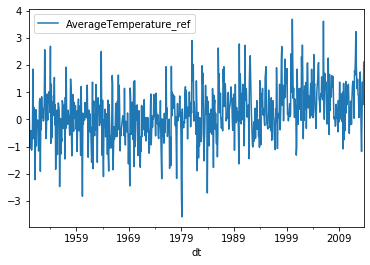

In [284]:
df.loc[df['Country']=='United States of America'].plot(x='dt',y='AverageTemperature_ref')

### Map data

In [285]:
df_stats_countries = pd.DataFrame(df.loc[df['Year']>end_reference_period].groupby('Country')['AverageTemperature_ref'].mean()).reset_index()

In [286]:
gdf = pd.merge(
    gdf,
    df_stats_countries,
    on='Country', how='left'
).rename(columns={'AverageTemperature_ref':'AverageTemperature_sinceRef'})
#gdf

## Plot data

In [287]:
#alt.data_transformers.enable('data_server') # data will be served in the background rather than embedded in the chart specification
#alt.data_transformers.enable('json')        # data will be serialized to disk and referenced by URL
alt.data_transformers.enable('default')    # data will be fully embedded in the notebook

DataTransformerRegistry.enable('default')

In [288]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
#df['AverageTemperature_ref'].quantile([0.05,.25,.5,.75,.95]).values.tolist()

In [289]:
domain = [-5,-.5,0,.5,5]
range_ = ['#0571b0','#92c5de','#f7f7f7','#f4a582','#ca0020']

In [290]:
sphere = alt.sphere()
graticule = alt.graticule()

source_map = gdf
source_heatmap = df[['Year','Month','Country','AverageTemperature_ref']]#.melt('index', var_name='category', value_name='value')

width = 900*1.25
height = 450*1.25

default_country = "Germany"
selector = alt.selection(
    type="single", fields=['Country'], init={"Country": default_country}
)

color = alt.condition(
    selector,
    alt.value('#FF00E8'), #alt.Color('idle_start_average_duration:Q'),
    #alt.value('black')
    alt.Color('AverageTemperature_sinceRef:Q', title='Temperature difference (°C)'),
)

background = alt.layer(
    alt.Chart(sphere).mark_geoshape(fill='#D5F5FF'),
    alt.Chart(graticule).mark_geoshape(stroke='white', strokeWidth=0.5),
    alt.Chart(source_map).mark_geoshape(fill='lightgrey', stroke='grey', strokeWidth=0.5)
).project(
    'naturalEarth1'
).properties(
    width=width, height=height
)

choropleth = alt.Chart(
    source_map, title=f'Average monthly temperature change for {end_reference_period+1}-{last_year} compared to {start_reference_period}-{end_reference_period}'
).mark_geoshape(
    stroke='grey', strokeWidth=0.5
).encode(
    color=color,
    tooltip=[
        'Country:N',
        alt.Tooltip('AverageTemperature_sinceRef:Q', title=f'Average monthly temperature change for {end_reference_period+1}-{last_year} compared to {start_reference_period}-{end_reference_period} (°C)', format='+.2f'),
    ]
).project(
    'naturalEarth1'
).properties(
    width=width, height=height
).add_selection(
    selector
)

heatmap = alt.Chart(
    source_heatmap, title=f'Average monthly temperature {first_year}-{last_year} (compared to the period {start_reference_period}-{end_reference_period})'
).mark_rect(
    #stroke='grey',
    #strokeWidth=0.5,
).encode(
    y=alt.Y('Month:O', sort=alt.EncodingSortField('Month', order='ascending')),
    x=alt.X('Year:O', sort=alt.EncodingSortField('Year', order='ascending')),
    color=alt.Color(
        'AverageTemperature_ref:Q',
        scale=alt.Scale(domain=domain, range=range_),
        #scale=alt.Scale(type='sqrt', scheme="redyellowblue", order="descending"), # domain=[max_value, -max_value]
        title='Temperature difference (°C)'
    ),
    tooltip=[
        'Country:N','Year:O','Month:O',
        alt.Tooltip('AverageTemperature_ref:Q', title=f'Average monthly temperature change compared to {start_reference_period}-{end_reference_period} (°C)', format='+.2f'),
    ]
).add_selection(
    selector
).transform_filter(
    selector
).properties(
    #width=height/((last_year-first_year)/12),
    #height=height
    width=width,
    height=width/((last_year-first_year)/12),
)

chart = ((background + choropleth) & heatmap).configure_legend(orient='right').configure_view(stroke=None)
#chart = (heatmap & (background + choropleth)).configure_legend(orient='right').configure_view(stroke=None)
#chart

In [291]:
file_name = f"world_temperature_{first_year}-{last_year}_ref{start_reference_period}-{end_reference_period}_map_heatmap"
print(file_name)

world_temperature_1950-2013_ref1961-1990_map_heatmap


In [292]:
chart.save(os.path.join(mainDir,'plots',file_name+'.html'))
#chart.save(os.path.join(mainDir,'plots',file_name+'.png'), scale_factor=1.5)